In [1]:
import numpy as np
import operator as op
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators
from sklearn.externals import six
from sklearn.base import clone, ClassifierMixin, BaseEstimator
from sklearn.neighbors import KNeighborsClassifier
# 模拟了 from sklearn.ensemble import VotingClassifier
# 继承了 BaseEstimator，获得了 get_params 和 set_params方法
# 继承了 ClassifierMixin， 获得了 score 方法
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        # 保存未训练的 classifier
        self.classifiers = classifiers
        # 保存全部基分类器的各种参数
        self.named_classifiers = {key: value 
                                  for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'" 
                             "; got (vote=%r)" % self.vote)
        
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError("Number of classifiers and weights must be equal" 
                             "; got %d weights, %d classifiers" 
                             % (len(self.weights), len(self.classifiers)))        
        
        self.labelenc_ = LabelEncoder()
        # 这个encoder是内部的，如果外部进行了encoder，此处可能会导致与外部不一致，因此最终输出时要inverse
        self.labelenc_.fit(y)
        transformed_y = self.labelenc_.transform(y)
        # 保存原始类别名称
        self.classes_ = self.labelenc_.classes_
        # 保存已训练的 classifier
        self.classififers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, transformed_y)
            self.classififers_.append(fitted_clf)
        return self
    
    def predict_proba(self, X):
        # 各个分类器输出的分类决策概率
        probas = [clf.predict_proba(X) for clf in self.classififers_]
        # 按实例的权重求加权平均，得到在各个样本的每个类别上的决策概率
        avg_probas = np.average(probas, axis=0, weights=self.weights)
        return avg_probas
    
    def predict(self, X):
        if self.vote == 'probability':
            # 各个分类器加权输出了每个样本各个类别的决策概率，则最终输出只要选择最大概率的那个就好
            # 因为输出类别已经做了LabelEncodeer，所以直接使用 argmax输出索引即是 encode之后的类别
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        elif self.vote == 'classlabel':
            predictions = np.array([clf.predict(X) for clf in self.classififers_]).T
            # 加权计票函数
            f = lambda x: np.argmax(np.bincount(x, weights=self.weights))
            maj_vote = np.apply_along_axis(arr=predictions, axis=1, func1d=f)
        # 在输出时重新转换回来
        return self.labelenc_.inverse_transform(maj_vote)
    
    def get_params(self, deep=True):
        # 如果 deep=False 则只需要到自身实例的参数即可
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        # 如果 deep=True 则需要深入到每个基分类器的具体参数
        else:
            out = self.named_classifiers.copy()
            # name: estimator的名字代号
            # method： estimator具体的方法实例
            for name, method in list(out.items()):
                # key： estimator的参数名称
                # value： estimator的参数值
                for key, value in list(method.get_params().items()):
                    out["%s__%s" % (name, key)] = value
        return out

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(metric='minkowski', p=2, n_neighbors=1)
# 由于 Logisitic 和 KNN都涉及标准化，因此利用 pipeline来整合。
pipe1 = Pipeline([('sc', StandardScaler()), ('clf', clf1)])
pipe3 = Pipeline([('sc', StandardScaler()), ('clf', clf3)])

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
classifiers = [pipe1, clf2, pipe3, mv_clf]
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN', 'Majority Voting']

In [3]:
iris = load_iris()
dat = iris.data
labels = iris.target
# 从 iris数据中只选出两类。
mask = np.isin(labels, [1, 2])
X = dat[mask][:, [1, 2]]
y = labels[mask]
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [32]:
# 输出基分类器和 mv的 auc
for label, clf in zip(clf_labels, classifiers):
    scores = cross_val_score(X=X_train, 
                             y=y_train, 
                             cv=5, 
                             scoring='roc_auc', 
                             estimator=clf)
    print("ROC AUC: %0.2f (+/- %0.2f) [%s] " % (scores.mean(), scores.std(), label))

ROC AUC: 0.91 (+/- 0.12) [Logistic Regression] 
ROC AUC: 0.93 (+/- 0.10) [Decision Tree] 
ROC AUC: 0.89 (+/- 0.10) [KNN] 
ROC AUC: 0.96 (+/- 0.06) [Majority Voting] 


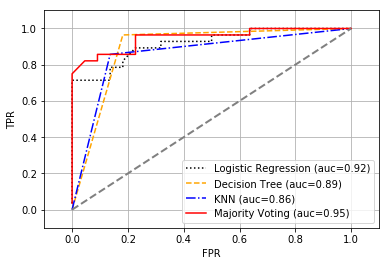

In [45]:
# 在测试数据上描绘 MajorityVoteClassifier和其他基分类器的 ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
colors = ['black', 'orange', 'blue', 'red']
linestyles = [':', '--', '-.', '-']
for label, clf, color, linestyle in zip(clf_labels, classifiers, colors, linestyles):
    clf.fit(X_train, y_train)
    # 令类别序号 = 1为正类
    y_pred_proba = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_true=y_test, 
                                     y_score=y_pred_proba[:, 1], 
                                     pos_label=1)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, 
             tpr, 
             color=color, 
             linestyle=linestyle, label="%s (auc=%0.2f)" % (label, roc_auc))
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()   

In [58]:
# 描绘决策区域，为了便于在同样的尺度下进行展示，因此还是需要对整体特征做标准化
from itertools import product
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
# 得到决策网格
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

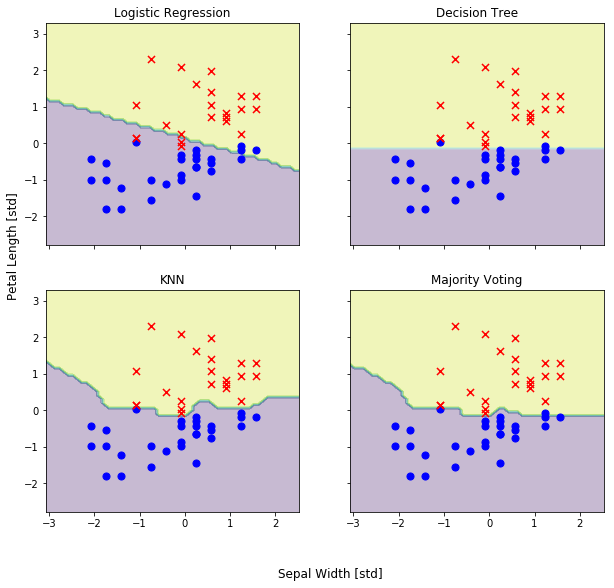

In [84]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex="col", sharey="row", figsize=(10, 9))
colors = ["blue", "red"]
markers = ["o", "x"]
y_labels = np.unique(y)
for idx, label, clf in zip(product([0, 1], [0, 1]), clf_labels, classifiers):
    clf.fit(X_train_std, y_train)
    z = clf.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape)
    axes[idx].contourf(xx, yy, z, alpha=0.3)
    for index, cl in enumerate(y_labels):
        axes[idx].scatter(x=X_train_std[y_train == cl, 0], 
                          y=X_train_std[y_train == cl, 1], 
                          c=colors[index], 
                          marker=markers[index], 
                          label=cl,
                          s=50)
    axes[idx].set_title(label)
#不能这样加坐标轴标题，因为plt是加到当前绘制的图（最后一个子图）里
#plt.xlabel("Sepal Width [std]")
#plt.ylabel("Petal length [std]")
plt.text(-3.5, -4.5, s="Sepal Width [std]", ha="center", va="center", fontsize=12)
plt.text(-10.5, 4.5, s="Petal Length [std]", ha="center", va="center", fontsize=12, rotation=90)
plt.show()

In [98]:
# mv_clf.get_params()
# 获得当前 estimator的全部参数名称，便于进行 GridSearch

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 

In [4]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2], 
          'pipeline-1__clf__C': [0.001, 0.1, 100]
         }
grid = GridSearchCV(cv=5, 
                    estimator=mv_clf, 
                    n_jobs=1, 
                    scoring="roc_auc", 
                    param_grid=params)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])],
            vote='classlabel', weights=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [19]:
import pandas as pd
gridSearchResult = pd.DataFrame(grid.cv_results_)
gridSearchResult[["mean_test_score", "params"]].head(5)

,mean_test_score,params
0,0.965667,"{'decisiontreeclassifier__max_depth': 1, 'pipe..."
1,0.965667,"{'decisiontreeclassifier__max_depth': 1, 'pipe..."
2,0.983667,"{'decisiontreeclassifier__max_depth': 1, 'pipe..."
3,0.965667,"{'decisiontreeclassifier__max_depth': 2, 'pipe..."
4,0.965667,"{'decisiontreeclassifier__max_depth': 2, 'pipe..."


In [20]:
print("best score: %0.3f ; best params: %s" % (grid.best_score_, grid.best_params_))

best score: 0.984 ; best params: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100}
